# **Environment**

In [4243]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# %%
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

#import classifiers
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.covariance import OAS
from sklearn.neural_network import MLPClassifier

#import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import KFold, StratifiedKFold,GridSearchCV, RandomizedSearchCV, cross_validate,cross_val_predict,learning_curve
from sklearn.pipeline import make_pipeline
from numpy import interp

# Taking care of missing data
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import tensorflow as tf

# import lib for export model files
import joblib

rng = np.random.RandomState(0)

import chardet
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Etudes\Doctorat\Application\CodeFindrisk'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# **Metrics Functions**


In [4244]:
n_dots = 50
tprs = []
mean_fpr = np.linspace(0, 1, 100)

def replace_zero(data, field, target):
    
    mean_by_target = data.loc[data[field] != 0, [field, target]].groupby(target).mean()
    data.loc[(data[field] == 0)&(data[target] == 0), field] = mean_by_target.iloc[0][0]
    data.loc[(data[field] == 0)&(data[target] == 1), field] = mean_by_target.iloc[1][0]
    
 # Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results["rank_test_score"] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print(
                "Mean validation score: {0:.3f} (std: {1:.3f})".format(
                    results["mean_test_score"][candidate],
                    results["std_test_score"][candidate],
                )
            )
            print("Parameters: {0}".format(results["params"][candidate]))
            print("")
            print(results.best_params_)
            print(results.best_score_)

def metrics(model_name, y_true, y_pred, probas_):
    '''
    Parameters :
    Input - 
    y_true - true  value of input data    
    y_pred- predicted  value of input data  
    probas_- probability/confidence of predicted output

    return -True Negative(tn),False Positive(fp),False Negative(fn)
    True positive(tp),AUC(roc_auc),False Positive Rate(fpr),
    True positive rate(tpr)

    '''
    
    points = n_dots*'-'
    #print(points)
    #print(model_name)
    #print(points)
    #report(results)
#    print("Best parameters set found on development set:")
#    print(clf.best_params_)
    fpr, tpr, thresholds = roc_curve(y_true, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    #aucs.append(roc_auc)
    #print("Detailed classification report for {}".format(model_name))
    #print()
    #print(classification_report(y_true, y_pred))
    #print()
    #print("Area Under ROC (AUC): {}".format(roc_auc))
    #print()
    #print("the cohen kappa : {}".format(cohen_kappa_score(y_true, y_pred)))
    #print()
    #print('Confusion Matrix for current fold: ')
    #print(confusion_matrix(y_true, y_pred))
    #print()
    #print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    #print()
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    return tn, fp, fn, tp, roc_auc, fpr, tpr


def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")
    
    return plt


# **Plot Functions**


In [4245]:
# Pairs plots are just showing all variables paired with all the other variables
def pair_plot(data):
    '''
    This function will create a grid of Axes such that each variable
    in data will by shared in the y-axis across a single row and in the x-axis
    across a single column.The diagonal Axes are treated differently, drawing 
    a plot to show the univariate distribution of the data for the variable in
    that column.
    Parameters :
    Input - data is the pandas type variable for 
    plotting pair plot of features in this
    dataframe 

    Output :
    This function Plot pairwise relationships in a dataset.

    '''
    plt.figure()

    pair_plot = sns.pairplot(data=data,
                             height=3,
                             hue='Outcome',
                             diag_kind='hist')
    # fig.suptitle("Pairplot of all features")
    pair_plot.fig.suptitle("Pairplot of all features")
    plt.show()

    # this function for Gaussian distribution plot
# and box plot simultaneously in a figure


def Box_Gaussian(data):
    '''
    Parameters :
    Input - data is the pandas type variable

    Output - The Gaussian distribution plot for
    eight feature of input data 

    '''

    from sklearn.preprocessing import StandardScaler

    sc_X = StandardScaler()

    fig = plt.figure(figsize=(15, 6))  # define figure size
    fig.suptitle("Box Gaussian plot of all features")

    n_scaler = StandardScaler()  # standardization function
    temp_Data = n_scaler.fit_transform(data)  # pass into function for standrd.
    for i in range(8):  # loop for all 8 feature

        plt.subplot(2, 4, i+1)  # subplot for 2 rows in 4 columns
        Data = temp_Data[:, i]  # data for every feature
        # kernel density function under red shaded arae
        sns.kdeplot(Data, shade=True, color='red', alpha=0.3)
        # boxplot  with green shaded area
        ax = sns.boxplot(Data, saturation=0.9, color="green")
        # https://seaborn.pydata.org/generated/seaborn.kdeplot.html
        # https://seaborn.pydata.org/generated/seaborn.boxplot.html
        plt.gca().invert_yaxis()  # Reverse Y-Axis in PyPlot
        # plt.title('F'+str(i+1))
        frame1 = plt.gca()
        frame1.axes.xaxis.set_ticklabels([])  # removing xlabel data
        plt.ylim((-0.5, 0.65))  # y axis  limit
        # This module provides routines to adjust subplot params so that subplots are nicely fit in the figure.
        plt.tight_layout()
        # https://matplotlib.org/api/tight_layout_api.html
        # plt.grid('on')

        for patch in ax.artists:
            # Get the facecolor of the Axes.
            r, g, b, a = patch.get_facecolor()
            patch.set_facecolor((r, g, b, 0.3))  # set colour intensity


def plot_confusionMatrix(data):
    '''
    Parameters :
    Input - data is the pandas type variable

    Output -visualization of correalation matrix of
    input data 

    '''
    sns.set(font_scale=1.15)                                    # Set aesthetic parameters in one step.
    # set figure size   https://seaborn.pydata.org/generated/seaborn.set.html
    ax = plt.figure(figsize=(10, 8))
    plt.title("Confusion Matrix of all features")
    sns.heatmap(data.corr(),                                    # input correlation matrix  of dataset
                vmax=1.0,  # Values to anchor the colormap, otherwise they are inferred from
                                                                # the data and other keyword arguments.
                vmin=0.0,
                linewidths=0.01,
                # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                square=False,
                annot=True,  # If True, write the data value in each cell.
                linecolor="black")  # Color of the lines that will divide each cell.
    # https://seaborn.pydata.org/generated/seaborn.heatmap.html
    # discover the values for bottom and top
    b, t = plt.ylim()
    # Add 0.5 to the bottom
    b += 0.5
    # Subtract 0.5 from the top
    t -= 0.5
    # update the ylim(bottom, top) values
    plt.ylim(b, t)
    plt.show()


# this function plot univariate distribution of
# every feature

def dist_Plot(data):
    '''
    Parameters :
    Input - data is the pandas type variable

    Output - The distribution plot for
    eight feature of input data 

    '''
    fig, ax = plt.subplots(2, 4, figsize=(
        12, 5))  # set numbers of rows and columns of subplot
    sns.set()
    # Flexibly plot a univariate distribution of observations.
    sns.distplot(data.F1, bins=10, ax=ax[0, 0])
    sns.distplot(data.F2, bins=10, ax=ax[0, 1])
    sns.distplot(data.F3, bins=10, ax=ax[0, 2])
    sns.distplot(data.F4, bins=10, ax=ax[0, 3])
    sns.distplot(data.F5, bins=10, ax=ax[1, 0])
    sns.distplot(data.F6, bins=10, ax=ax[1, 1])
    sns.distplot(data.F7, bins=10, ax=ax[1, 2])
    sns.distplot(data.F8, bins=10, ax=ax[1, 3])
    fig.suptitle("Gaussian Distribution of all features")
    fig.tight_layout()  # This module provides routines to adjust subplot params
    #  so that subplots are nicely fit in the figure.


# this function plot violin plot  of
# every feature


def plot_violinplot(data):
    '''
    Parameters :
    Input - data is the pandas type variable

    Output - The violinplot plot for
    eight feature of input data 

    '''

    # A violin plot is a method of plotting numeric data.
    # It is similar to box plot with a rotated kernel
    # density plot on each side. Violin plots are similar
    # to box plots, except that they also show the probability
    # density of the data at different values (in the simplest
    # case this could be a histogram).
    fig, ax = plt.subplots(2, 4, figsize=(12, 6))
    # #set numbers of rows and columns of subplot and figure size
    sns.set()
    # violine plot for F1 feature
    sns.violinplot(x=data.Outcome, y=data.F1,  ax=ax[0, 0])
    # violine plot for F2 feature
    sns.violinplot(x=data.Outcome, y=data.F2,  ax=ax[0, 1])
    # violine plot for F3 feature
    sns.violinplot(x=data.Outcome, y=data.F3,  ax=ax[0, 2])
    # violine plot for F4 feature
    sns.violinplot(x=data.Outcome, y=data.F4,  ax=ax[0, 3])
    # violine plot for F5 feature
    sns.violinplot(x=data.Outcome, y=data.F5,  ax=ax[1, 0])
    # violine plot for F6 feature
    sns.violinplot(x=data.Outcome, y=data.F6,  ax=ax[1, 1])
    # violine plot for F7 feature
    sns.violinplot(x=data.Outcome, y=data.F7,  ax=ax[1, 2])
    # violine plot for F8 feature
    sns.violinplot(x=data.Outcome, y=data.F8,  ax=ax[1, 3])
    fig.suptitle("Violin plot of all features")
    fig.tight_layout()

    # https://seaborn.pydata.org/generated/seaborn.violinplot.html
    #
    #

# data plot on different input condition


def data_plot(data,
              Pair_plot,
              Dist_Plot,
              Plot_violinplot,
              Plot_confusionMatrix,
              box_Gaussian):
    '''
    Parameters :
    Input - 
    data - It is the pandas type variable
    Pair_plot - for pair plot visualization of input  data  
    Dist_Plot- for gaussian distribution plot visualization of input  data  
    Plot_violinplot- for violin plot visualization of input  data  
    Plot_confusionMatrix -for confusion matrix visualization of input  data   

    Output - dataframe with outleir rejection
    filled with Input parameter

    '''
    if Pair_plot == True:
        pair_plot(data)

    if Dist_Plot == True:
        dist_Plot(data)

    if Plot_violinplot == True:
        plot_violinplot(data)

    if Plot_confusionMatrix == True:
        plot_confusionMatrix(data)

    if box_Gaussian == True:
        Box_Gaussian(data)


def average_ROC(mean_fpr, tprs, aucs, TP, TN, FP, FN):
    '''
    Parameters :
    mean_fpr - Mean False positive rate
    tprs -values of true positive rate
    aucs  - values of auc
    TP    - True positive 
    TN    - True Negative
    FP    - False Positiv
    FN    - False Negative

    Output - 
    Visalization of TPR vs FPR plot
    '''
    sen = (np.sum(TP))/(np.sum(TP)+np.sum(FN))
    spe = (np.sum(TN))/(np.sum(TN)+np.sum(FP))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    # mean_auc = auc(mean_fpr, mean_tpr)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    # plt.figure(figsize=(8, 5))
    # plt.grid(True)
    ax = plt.axes()
    ax.grid(color='lightgray', linestyle='-', linewidth=.5)
    # Setting the background color
    ax.set_facecolor("white")

    ax.spines['bottom'].set_color('#000000')
    ax.spines['top'].set_color('#000000')
    ax.spines['right'].set_color('#000000')
    ax.spines['left'].set_color('#000000')

    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Avg. ROC (AUC (avg $\pm$ std) = %0.3f $\pm$ %0.3f)' % (
                 mean_auc, std_auc),
             lw=2, alpha=.8)

    plt.scatter((1-spe), sen, s=80, c='r', marker='x',)
    plt.scatter(0, sen, s=80, c='r', marker='x',)
    plt.scatter((1-spe), 0, s=80, c='r', marker='x',)
    plt.axhline(y=sen, color='r', linestyle='--')
    plt.axvline(x=(1-spe), color='r', linestyle='--')
    plt.text((1-spe), 0.02, "FPR={:0.3f}".format((1-spe)))
    plt.text(0.009, sen+0.05, "TPR={:0.3f}".format(sen))

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='darkgray', alpha=0.5,
                     label=r'$\pm$ 1 Standard deviation')

    plt.xticks(np.arange(0.0, 1.01, step=0.1))
    plt.yticks(np.arange(0.0, 1.01, step=0.1))
    left = 0.0
    right = 1.0
    plt.xlim(left, right)
    plt.ylim(left, right)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.legend(loc="lower right")
    # plt.grid(True)
    plt.show()


# **OutlierRejection Functions**


In [4246]:
Renamed_feature = []  # list of names that will rename to feature column
all_clf_res = []  # every classifier auc values are stored in it
random_initializer = 20  # random initializer

for i in range(10):
    # for renaming dataset of columns features F1 -- F8
    Renamed_feature.append('F'+str(i+1))
# this function  is for manual outleir rejection


def IQR(data):
    '''
    Parameters :
    Input - data is the pandas type variable

    Return - dataframe with outleir rejection
    of input data 

    '''
    # input dataset as data
    # for every feature
    for i in range(data.shape[1]-1):
        Q1 = data[Renamed_feature[i]].quantile(0.25)
        Q3 = data[Renamed_feature[i]].quantile(0.75)
        IQR = Q3-Q1  # find IQR
        LW = (Q1 - 1.5 * IQR)  # find lower boundary
        # print(LW)
        UW = (Q3 + 1.5 * IQR)  # find upper boundary
        # print(UW)
        # drop greater than upper limit
        data = data[data[Renamed_feature[i]] < UW]
        # drop smaller than lower limit
        data = data[data[Renamed_feature[i]] > LW]

    return data

# outlier rejection with different condition


def outlier_Rejection(data, iqr):
    '''
    Parameters :
    Input - 
    data is the pandas type variable
    iqr- for drop the outleir 
    Return - dataframe with outleir rejection
    filled with Input parameter
    '''
    
    # outlier_Rejection with conditional input
    if iqr == True:  # reject outleir in IQR range
        data = IQR(data)

    return data


# **Pima Indian**


In [4247]:

with open("Data/diabetes.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

train = pd.read_csv("Data/diabetes.csv", encoding='ISO-8859-1')


# **Findrisk MyData**


with open("Data/MydataFindriskNonOui.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

train = pd.read_csv("Data/MydataFindriskNonOui.csv", encoding='UTF8')


# **Explore the data**


In [4248]:
train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4249]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4250]:
# importing plotly and cufflinks in offline mode
import cufflinks as cf
import plotly.offline
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
train.iplot()

C:\Users\VirWus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='Outcome', ylabel='count'>

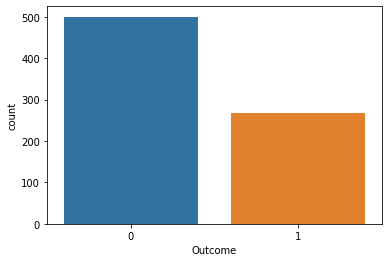

In [4251]:
sns.countplot(train['Outcome'])

# **Create X and Y data**


In [4252]:
X = train.drop([
    # 'Score',
    'Outcome'], axis=1)

y = train['Outcome']
X.shape

(768, 8)

# **Rename Features**


In [4253]:
data = pd.DataFrame({'F1': X.iloc[:, :10].values[:, 0],
                     'F2': X.iloc[:, :10].values[:, 1],
                     'F3': X.iloc[:, :10].values[:, 2],
                     'F4': X.iloc[:, :10].values[:, 3],
                     'F5': X.iloc[:, :10].values[:, 4],
                     'F6': X.iloc[:, :10].values[:, 5],
                     'F7': X.iloc[:, :10].values[:, 6],
                     'F8': X.iloc[:, :10].values[:, 7],
                     #'F9':X.iloc[:,:10].values[:,8],
                     #'F10':X.iloc[:,:10].values[:,9],
                     'Outcome': y})
data.head()


,F1,F2,F3,F4,F5,F6,F7,F8,Outcome
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


# **Impute Missing Data**


In [4254]:

estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=rng,
    ),
    KNeighborsRegressor(n_neighbors=15),
]
#imputer= SimpleImputer(strategy='mean')
imputer = IterativeImputer(random_state=rng, estimator=estimators[0], max_iter=25)

imputer = imputer.fit_transform(data[["F1",
                            "F2",
                            "F3",
                            "F4",
                            "F5",
                            "F6",
                            "F7",
                            "F8",
                            #"F9",
                            "Outcome"]])


In [4255]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   F1       768 non-null    float64
 1   F2       768 non-null    float64
 2   F3       768 non-null    float64
 3   F4       768 non-null    float64
 4   F5       768 non-null    float64
 5   F6       768 non-null    float64
 6   F7       768 non-null    float64
 7   F8       768 non-null    float64
 8   Outcome  768 non-null    int64  
dtypes: float64(8), int64(1)
memory usage: 54.1 KB


# **Correlation Map and Figures**


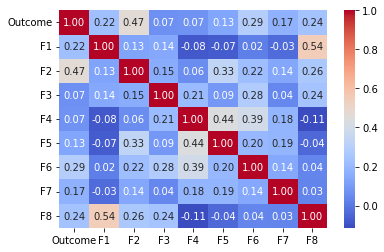

In [4256]:
g = sns.heatmap(data[["Outcome",
                      "F1",
                      "F2",
                      "F3",
                      "F4",
                      "F5",
                      "F6",
                      "F7",
                      "F8",
                      #"F9"
                      ]].corr(), annot=True, fmt=".2f", cmap="coolwarm")


# **Outlier Rejection and Replace Zero**


In [4257]:
print('Shape Before Process: ' + str(data.shape))
data = outlier_Rejection(data,
                         iqr=True,
                       )
print('Shape After outlier Removed: ' + str(data.shape))

for col in ['F2', 'F3', 'F4', 'F5', 'F6']:   
    replace_zero(data, col, 'Outcome')              
print('Shape After Filling Missing Value: ' + str(data.shape))

Shape Before Process: (768, 9)
Shape After outlier Removed: (636, 9)
Shape After Filling Missing Value: (636, 9)


# **NEW X and Y**

In [4258]:
X = data.drop(['Outcome'], axis=1)
y = data['Outcome']
X

,F1,F2,F3,F4,F5,F6,F7,F8
0,6.0,148.0,72.0,35.000000,171.474227,33.6,0.627,50.0
1,1.0,85.0,66.0,29.000000,113.606695,26.6,0.351,31.0
2,8.0,183.0,64.0,32.059259,171.474227,23.3,0.672,32.0
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0
5,5.0,116.0,74.0,27.094512,113.606695,25.6,0.201,30.0
...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0
764,2.0,122.0,70.0,27.000000,113.606695,36.8,0.340,27.0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0
766,1.0,126.0,60.0,32.059259,171.474227,30.1,0.349,47.0


# **Smote Sampling**


In [4259]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)


<AxesSubplot:title={'center':'Count (Class)'}>

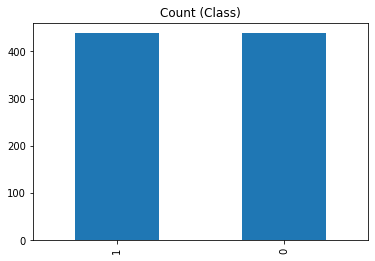

In [4260]:
y_sm.value_counts().plot(kind='bar', title='Count (Class)')


# **Split Data**


# **Label Encoding**

In [4261]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder = LabelEncoder()
#train[["Sex","Age","BMI","Waist","Sport30min","Vegetables","Hypertension","Glucose","Familly","Score"]] = labelencoder.fit_transform(train[["Sex","Age","BMI","Waist","Sport30min","Vegetables","Hypertension","Glucose","Familly","Score"]])
data["F1"] = labelencoder.fit_transform(data[["F1"]])
data["F2"] = labelencoder.fit_transform(data[["F2"]])
data["F3"] = labelencoder.fit_transform(data[["F3"]])
data["F4"] = labelencoder.fit_transform(data[["F4"]])
data["F5"] = labelencoder.fit_transform(data[["F5"]])
data["F6"] = labelencoder.fit_transform(data[["F6"]])
data["F7"] = labelencoder.fit_transform(data[["F7"]])
data["F8"] = labelencoder.fit_transform(data[["F8"]])
#data["F9"] = labelencoder.fit_transform(data[["F9"]])
data["Outcome"] = labelencoder.fit_transform(data[["Outcome"]])

C:\Users\VirWus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [4262]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2,random_state=rng)
X_train


,F1,F2,F3,F4,F5,F6,F7,F8
45,0.000000,105.000000,64.000000,41.000000,142.000000,41.500000,0.173000,22.000000
172,2.000000,81.000000,60.000000,22.000000,113.606695,27.700000,0.290000,25.000000
492,0.000000,188.000000,82.000000,14.000000,185.000000,32.000000,0.682000,22.000000
820,5.368840,132.904928,71.452464,32.059259,171.474227,26.647187,0.379663,55.893480
651,7.547273,172.378186,89.094547,37.621814,309.507260,35.737270,0.611873,49.850920
...,...,...,...,...,...,...,...,...
835,7.014293,184.057171,83.914243,32.986554,171.474227,35.677231,0.351884,41.028586
192,7.000000,181.000000,84.000000,21.000000,192.000000,35.900000,0.586000,51.000000
629,9.000000,170.000000,74.000000,31.000000,171.474227,44.000000,0.403000,43.000000
559,3.000000,121.000000,52.000000,32.059259,171.474227,36.000000,0.127000,25.000000


# **Feature Scaling**


In [4263]:
# Feature scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

npX = np.array(X_train).copy()
npy = np.array(y_train).copy()

#Scaler Variable
sc_X = StandardScaler()
mms_X = MinMaxScaler()
rs_X = RobustScaler()

# ROBUST Scaller
#Scaler Transormation 
# rs_X = rs_X.fit(npX)

# npX = rs_X.transform(npX)
# X_test = rs_X.transform(X_test)

# MinMax Scaller
#Scaler Transormation 
# mms_X = mms_X.fit(npX)

# npX = mms_X.transform(npX)
# X_test = mms_X.transform(X_test)

# Standard Scaller
#Scaler Transormation 
sc_X = sc_X.fit(npX)

npX = sc_X.transform(npX)
X_test = sc_X.transform(X_test)




C:\Users\VirWus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:444: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



# **Feature Selection Reduce dimension**

In [4264]:
from sklearn.decomposition import PCA
#import prince
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2

#mca = prince.MCA(n_components=6, n_iter=3, copy=True, check_input=True, engine='auto', random_state=rng)

fs = SelectKBest(score_func=mutual_info_classif, k='all')

fs.fit(npX,npy)

npX = fs.transform(npX)
X_test = fs.transform(X_test)
 
#Pca Transformation
# pca = PCA(n_components=6)

# pca.fit(npX)
# npX = pca.transform(npX)
# X_test = pca.transform(X_test)

npX

array([[-1.32935559, -0.64441391, -0.83327738, ...,  1.44680083,
        -1.12470212, -1.10820795],
       [-0.69795057, -1.43320372, -1.20424337, ..., -0.79006921,
        -0.63318688, -0.82249192],
       [-1.32935559,  2.08348418,  0.83606961, ..., -0.09307347,
         1.01359921, -1.10820795],
       ...,
       [ 1.511967  ,  1.49189182,  0.09413761, ...,  1.85203091,
        -0.15847558,  0.89180428],
       [-0.38224806, -0.11855404, -1.94617537, ...,  0.55529465,
        -1.31794743, -0.82249192],
       [-0.16414688,  1.32600522,  0.27962061, ...,  2.29310629,
        -0.39673886, -0.65695102]])

# **Plot the data**

In [4265]:
# data_plot(data,
#           Pair_plot=True,
#           Dist_Plot=True,
#           Plot_violinplot=True,
#           Plot_confusionMatrix=True,
#           box_Gaussian=False)


# **Top Feature Function**

In [4266]:
def TopF(model):
    topF=[]
    if hasattr(model, 'feature_importances_'):
        TOP_FEATURES = 6
        importances = model.feature_importances_
        #std = np.std([tree.feature_importances_ for tree in model.estimators_],axis=0)
        indices = np.argsort(importances)[::-1]
        indices = indices[:TOP_FEATURES]

        #print('Top features:')

        for f in range(TOP_FEATURES):
            d = [X_train.columns[indices[f]], importances[indices[f]]]
            topF.append(d)
            #print('%d. %s (%f)' % (f + 1,X_train.columns[indices[f]], importances[indices[f]]))
            
    return topF

# **Variable Declaration**

In [4267]:
clf_Gb = GaussianNB()
clf_rf = RandomForestClassifier(random_state=rng)
clf_knn = KNeighborsClassifier()
clf_et = ExtraTreesClassifier(n_estimators=1000,random_state=rng)
clf_bc = BaggingClassifier(random_state=rng)
clf_ab = AdaBoostClassifier(random_state=rng)
clf_dt = DecisionTreeClassifier(random_state=rng)
clf_xg = XGBClassifier(use_label_encoder=False,random_state=rng)
clf_lr = LogisticRegression(random_state=rng)
clf_svm = SVC(kernel='rbf', probability=True,random_state=rng)
#clf_pa = PassiveAggressiveClassifier()
oa = OAS(store_precision=False, assume_centered=False)
clf_lda = LinearDiscriminantAnalysis(solver="lsqr", covariance_estimator=oa)
clf_MLP = MLPClassifier(solver='lbfgs', alpha=1e-5,
                        hidden_layer_sizes=(5, 2), random_state=rng)
clf_QDA = QuadraticDiscriminantAnalysis()


n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49]
leaf_size = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Distance = [1, 2]

var_smoothing = [1e-01,
                 1e-02,
                 1e-03,
                 1e-04,
                 1e-05,
                 1e-06,
                 1e-07,
                 1e-08,
                 1e-09,
                 1e-10,
                 1e-11,
                 1e-12]


tuned_parameters = {"GaussianNB": [{'var_smoothing': var_smoothing}],
                    "KNeighbors": [{'n_neighbors': n_neighbors,  # define parameters with different algorithm
                                    'algorithm': ['brute'],
                                    'p':Distance},

                                   {'n_neighbors': n_neighbors,
                                    'algorithm': ['ball_tree'],
                                    'leaf_size': leaf_size,
                                    'p':Distance},

                                   {'n_neighbors': n_neighbors,
                                    'algorithm': ['kd_tree'],
                                    'leaf_size': leaf_size,
                                    'p':Distance}],   
                    "RandomForest": [{'criterion': ['gini', 'entropy']}],
                    "ExtraTrees": [{'criterion': ['gini', 'entropy']}],
                    "Bagging": [{}],
                    "AdaBoost": [{'algorithm': ['SAMME', 'SAMME.R'],
                                  'learning_rate':[0.1, 0.5, 1.0],
                                  'n_estimators': [10, 50, 100, 200]}],
                    "DecisionTree": [{'criterion': ['gini', 'entropy'],
                                      'splitter': ['best'],
                                      'min_samples_split':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                      'min_samples_leaf': [1, 2, 3, 4, 5]}],
                    "XGB": [{
                        'min_child_weight': [1, 5, 10],
                        'gamma': [0.5, 1, 1.5, 2, 5],
                        'subsample': [0.5, 1.0],
                        'colsample_bytree': [0.6, 0.8, 1.0],
                        'max_depth': [3, 4, 5]
                    }],
                    "LogisticRegression": [{}],
                    "SVC": [{}],
                    "MLP": [{}],
                    "LinearDiscriminantAnalysis": [{}],
                    "QDA": [{}],
                    }

Classifiers = ['GaussianNB',
               'KNeighbors',
               'RandomForest',
               'ExtraTrees',
               'Bagging',
               'AdaBoost',
               'DecisionTree',
               'XGB',
               'LogisticRegression',
               'SVC',
               #'PassiveAggresive',
               'MLP',
               'LinearDiscriminantAnalysis',
               "QDA"
               ]

scores = []
results = []

#space = dict()
models = [clf_Gb,
          clf_knn,
          clf_rf,
          clf_et,
          clf_bc,
          clf_ab,
          clf_dt,
          clf_xg,
          clf_lr,
          clf_svm,
          #clf_pa,
          clf_lda,
          clf_MLP,
          clf_QDA
          ]

# for store the value of accuracy
Accuracy = []
# for store False Positive
FP = []
# for True Negative
TN = []
# for False Negative
FN = []
# for True Positive
TP = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=rng)


# **Hyperparameters Tuned**

In [4268]:
def TunedParams(model,model_name,npX,npy):
    # split in train and test
    for train_index, test_index in kf.split(npX, npy):

        clf = GridSearchCV(model,
                           tuned_parameters[model_name.replace(
                               'Classifier', '')],
                           cv=5,
                           scoring=('accuracy', 'f1', 'roc_auc',
                                    'precision', 'recall'),
                           refit='roc_auc',
                           #n_iter=10,
                           n_jobs=-1)
        clf.fit(npX, npy)
        
        report(results = clf, n_top=1)


# **Train The Data**

In [4269]:
#fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(80, 80))
# p=1
from sklearn.pipeline import Pipeline 


for model in models:

    #fig = plt.figure(figsize=(10, 7))
    
    model_name = type(model).__name__
    
    #pipeline = Pipeline(steps=[("scaler", sc_X), ("MI", fs), (model_name, model)])
    
    score = cross_validate(model, npX, npy, scoring=(
        'accuracy', 'f1', 'roc_auc', 'precision', 'recall','neg_mean_squared_error'), cv=5, n_jobs=-1)

    model.fit(npX, npy)

    tn, fp, fn, tp, roc_auc, fpr, tpr = metrics(model_name,
                                                y_true=y_test,  # get the values of  model evaluation
                                                y_pred=model.predict(X_test),
                                                probas_=model.predict_proba(X_test)
                                                )

    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    TN.append(tn)
    FP.append(fp)
    FN.append(fn)
    TP.append(tp)
    
    # average_ROC(mean_fpr, tprs, roc_auc, TP, TN, FP, FN)  # plot average roc curve

    topF = TopF(model)
    
    #print(score['neg_mean_squared_error'].mean())
    
    data = [format(score['test_accuracy'].mean(), ".3f"), format(score['test_accuracy'].std(), ".3f"), format(score['test_f1'].mean(), ".3f"), format(score['test_f1'].std(), ".3f"), format(score['test_roc_auc'].mean(), ".3f"), format(score['test_roc_auc'].std(
    ), ".3f"), format(score['test_precision'].mean(), ".3f"), format(score['test_precision'].std(), ".3f"), format(score['test_recall'].mean(), ".3f"), format(score['test_recall'].std(), ".3f"), format(cohen_kappa_score(y_test, model.predict(X_test)), ".3f"), topF]
    
    scores.append(data)
    
    #fig, axes = plt.subplots(1, 3, figsize=(20, 5))   
    
    # disp = ConfusionMatrixDisplay.from_estimator(
    #     pipeline,
    #     X_test,
    #     y_test,
    #     display_labels={"Normal","Diabetes"},
    #     cmap=plt.cm.Blues,

    # )
    
    #disp.ax_.set_title(model_name)
    
    #plot_learning_curve(pipeline,model_name, npX, npy,axes=axes, ylim=(0.7, 1.01), cv=5, n_jobs=-1)
    

    # degrees = [1, 4, 15]
    # for i in range(len(degrees)):
    #     ax = plt.subplot(1, len(degrees), i + 1)
    #     plt.setp(ax, xticks=(), yticks=())
        
    #     plt.plot(X_test, model.predict(X_test), label="Model")
    #     plt.plot(X_test, np.cos(1.5 * np.pi * X_test), label="True function")
    #     #plt.scatter(npX, npy, edgecolor="b", s=20, label="Samples")
    #     plt.xlabel("x")
    #     plt.ylabel("y")
    #     plt.xlim((0, 1))
    #     plt.ylim((-2, 2))
    #     plt.legend(loc="best")
    #     plt.title(
    #         "Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
    #             degrees[i], -score['neg_mean_squared_error'].mean(), score['neg_mean_squared_error'].std()
    #         )
    #     )
    #     plt.show()
    
   
    
   

#     fig, ax = plt.subplots()
#     predicted = cross_val_predict(model, npX, npy, cv=5)
#     ax.scatter(npy, predicted, edgecolors=(0, 0, 0))
#     ax.plot([npy.min(), npy.max()], [npy.min(), npy.max()], "k--", lw=4)
#     ax.set_xlabel("Measured")
#     ax.set_ylabel("Predicted")
#     plt.show()

#     joblib_modelfile = "Models/"+model_name+".sav"
#     pipe = make_pipeline(sc_X, pca, model)
#     joblib.dump(pipe, joblib_modelfile)

#     axis labels
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     show the legend
#     plt.legend()
#     show the plot
#     plt.show()


[01:08:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\VirWus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html



# **ANN Model**

clf_ANN = tf.keras.models.Sequential()
#Adding First Hidden Layer
clf_ANN.add(tf.keras.layers.Dense(units=8,activation="relu"))
#Adding Second Hidden Layer
clf_ANN.add(tf.keras.layers.Dense(units=8,activation="relu"))
clf_ANN.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))
#Compiling ANN
clf_ANN.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])

clf_ANN.fit(npX,npy,epochs=100)
clf_ANN.evaluate(y_test,X_test, verbose=2)


# **Show Results**

In [4270]:
mode = pd.DataFrame(scores, index=Classifiers, columns=['Accuracy','A +/-', 'F1 score','F1 +/-', 'Roc_Auc','Roc +/-', 'Precision','Pr +/-', 'Recall','Re +/-','CK', 'Top']).sort_values(by='Roc_Auc', ascending=False)
mode.explode('Top')

,Accuracy,A +/-,F1 score,F1 +/-,Roc_Auc,Roc +/-,Precision,Pr +/-,Recall,Re +/-,CK,Top
ExtraTrees,0.921,0.017,0.923,0.017,0.975,0.010,0.909,0.022,0.937,0.026,0.830,"[F5, 0.27854982726554206]"
ExtraTrees,0.921,0.017,0.923,0.017,0.975,0.010,0.909,0.022,0.937,0.026,0.830,"[F2, 0.1800570215063006]"
ExtraTrees,0.921,0.017,0.923,0.017,0.975,0.010,0.909,0.022,0.937,0.026,0.830,"[F4, 0.13451515807309797]"
ExtraTrees,0.921,0.017,0.923,0.017,0.975,0.010,0.909,0.022,0.937,0.026,0.830,"[F6, 0.10170776060473889]"
ExtraTrees,0.921,0.017,0.923,0.017,0.975,0.010,0.909,0.022,0.937,0.026,0.830,"[F8, 0.09427178132149484]"
ExtraTrees,0.921,0.017,0.923,0.017,0.975,0.010,0.909,0.022,0.937,0.026,0.830,"[F1, 0.08347550539671904]"
RandomForest,0.909,0.020,0.909,0.020,0.971,0.009,0.902,0.019,0.917,0.028,0.830,"[F5, 0.3629806549434191]"
RandomForest,0.909,0.020,0.909,0.020,0.971,0.009,0.902,0.019,0.917,0.028,0.830,"[F4, 0.18395124770751844]"
RandomForest,0.909,0.020,0.909,0.020,0.971,0.009,0.902,0.019,0.917,0.028,0.830,"[F2, 0.14786295914606234]"
RandomForest,0.909,0.020,0.909,0.020,0.971,0.009,0.902,0.019,0.917,0.028,0.830,"[F8, 0.07893668608177688]"
